In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [2]:
import os, json, numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt, seaborn as sns

cwd = os.getcwd()
PROJECT_ROOT = os.path.dirname(cwd) if os.path.basename(cwd).lower()=="notebooks" else cwd

DATA_DIR = os.path.join(PROJECT_ROOT, "data")
OUT_DIR  = os.path.join(PROJECT_ROOT, "outputs")
FIG_DIR  = os.path.join(OUT_DIR, "figures"); os.makedirs(FIG_DIR, exist_ok=True)
MET_DIR  = os.path.join(OUT_DIR, "metrics"); os.makedirs(MET_DIR, exist_ok=True)
CKPT_DIR = os.path.join(OUT_DIR, "checkpoints"); os.makedirs(CKPT_DIR, exist_ok=True)

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32   # if you hit memory issues, set to 16
SEED       = 42

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR,"train"),
    image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    label_mode="categorical", seed=SEED, shuffle=True
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR,"val"),
    image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    label_mode="categorical", seed=SEED, shuffle=False
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR,"test"),
    image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    label_mode="categorical", seed=SEED, shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
class_names, num_classes


PROJECT_ROOT: C:\cv_partb
DATA_DIR: C:\cv_partb\data
Found 4636 files belonging to 4 classes.
Found 993 files belonging to 4 classes.
Found 997 files belonging to 4 classes.


(['Tomato_Bacterial_spot',
  'Tomato_Early_blight',
  'Tomato_Late_blight',
  'Tomato_healthy'],
 4)

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

def prep(ds, training=False):
    if training:
        return ds.cache().shuffle(1000).prefetch(AUTOTUNE)
    else:
        return ds.cache().prefetch(AUTOTUNE)

train_prep = prep(train_ds, training=True)
val_prep   = prep(val_ds,   training=False)
test_prep  = prep(test_ds,  training=False)


In [4]:
from tensorflow import keras
from tensorflow.keras import layers

data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.RandomContrast(0.1),
])

preprocess = tf.keras.applications.mobilenet_v2.preprocess_input

base = tf.keras.applications.MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base.trainable = False  # Phase 1

inputs = keras.Input(shape=(*IMG_SIZE,3))
x = data_aug(inputs) 
x = preprocess(x) 
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
modelB = keras.Model(inputs, outputs)

modelB.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
modelB.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
ckptB1 = os.path.join(CKPT_DIR, "modelB_phase1_best.keras")
callbacks1 = [
    keras.callbacks.ModelCheckpoint(ckptB1, monitor="val_accuracy", mode="max",
                                    save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max",
                                  patience=4, restore_best_weights=True),
]

hist1 = modelB.fit(
    train_prep,
    validation_data=val_prep,
    epochs=10,
    callbacks=callbacks1,
    verbose=1
)


Epoch 1/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.6433 - loss: 0.8704
Epoch 1: val_accuracy improved from None to 0.86606, saving model to C:\cv_partb\outputs\checkpoints\modelB_phase1_best.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 142s 933ms/step - accuracy: 0.7634 - loss: 0.6182 - val_accuracy: 0.8661 - val_loss: 0.3574
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - accuracy: 0.8775 - loss: 0.3478
Epoch 2: val_accuracy improved from 0.86606 to 0.90332, saving model to C:\cv_partb\outputs\checkpoints\modelB_phase1_best.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 129s 891ms/step - accuracy: 0.8855 - loss: 0.3256 - val_accuracy: 0.9033 - val_loss: 0.2663
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.9077 - loss: 0.2736
Epoch 3: val_accuracy improved from 0.90332 to 0.91843, saving model to C:\cv_partb\outputs\checkpoints\modelB_phase1_best.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 134s 923ms/step - accuracy: 0.9098 - loss: 0.2641 - val_accuracy: 0.9184 - val_lo

In [6]:
base.trainable = True
N = 40
for layer in base.layers[:-N]:
    layer.trainable = False

modelB.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

ckptB2 = os.path.join(CKPT_DIR, "modelB_phase2_best.keras")
callbacks2 = [
    keras.callbacks.ModelCheckpoint(ckptB2, monitor="val_accuracy", mode="max",
                                    save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max",
                                  patience=5, restore_best_weights=True),
]
hist2 = modelB.fit(
    train_prep,
    validation_data=val_prep,
    epochs=20,
    callbacks=callbacks2,
    verbose=1
)


Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8580 - loss: 0.3964
Epoch 1: val_accuracy improved from None to 0.89426, saving model to C:\cv_partb\outputs\checkpoints\modelB_phase2_best.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.9180 - loss: 0.2331 - val_accuracy: 0.8943 - val_loss: 0.2741
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9665 - loss: 0.1007
Epoch 2: val_accuracy improved from 0.89426 to 0.89728, saving model to C:\cv_partb\outputs\checkpoints\modelB_phase2_best.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9681 - loss: 0.0955 - val_accuracy: 0.8973 - val_loss: 0.2973
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9822 - loss: 0.0489
Epoch 3: val_accuracy improved from 0.89728 to 0.92447, saving model to C:\cv_partb\outputs\checkpoints\modelB_phase2_best.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9821 - loss: 0.0489 - val_accuracy: 0.9245 - val_loss: 0.2570
Epoch 4

                       precision    recall  f1-score   support

Tomato_Bacterial_spot       1.00      0.99      1.00       320
  Tomato_Early_blight       0.99      0.94      0.96       150
   Tomato_Late_blight       0.97      0.99      0.98       287
       Tomato_healthy       0.99      1.00      1.00       240

             accuracy                           0.99       997
            macro avg       0.99      0.98      0.98       997
         weighted avg       0.99      0.99      0.99       997



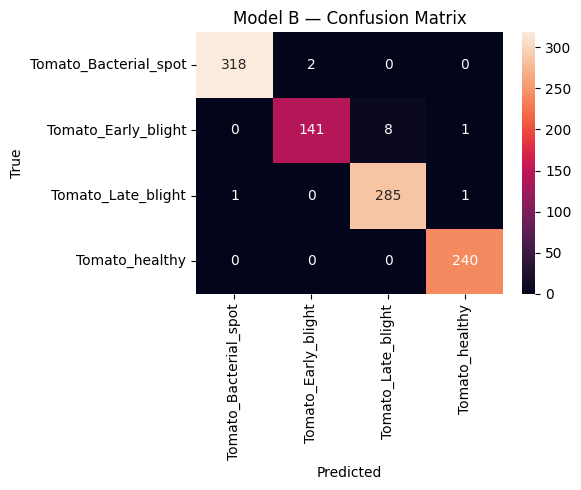

In [7]:
bestB = tf.keras.models.load_model(ckptB2)

y_trueB, y_predB = [], []
for bx, by in test_prep:
    probs = bestB.predict(bx, verbose=0)
    y_predB.extend(np.argmax(probs, axis=1))
    y_trueB.extend(np.argmax(by.numpy(), axis=1))

print(classification_report(y_trueB, y_predB, target_names=class_names))

cmB = confusion_matrix(y_trueB, y_predB)
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmB, annot=True, fmt="d",
            xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_title("Model B — Confusion Matrix")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout()
fig.savefig(os.path.join(FIG_DIR, "modelB_confusion_matrix.png"), dpi=150)
plt.show()

reportB = classification_report(y_trueB, y_predB, target_names=class_names, output_dict=True)
with open(os.path.join(MET_DIR, "modelB_classification_report.json"), "w") as f:
    json.dump(reportB, f, indent=2)


In [1]:
# Inspect one batch from the training dataset
for bx, by in train_ds.take(1):
    print("X shape:", bx.shape, bx.dtype)
    print("Y shape:", by.shape, by.dtype)
    # Peek at first 3 labels
    print("First 3 labels:\n", by[:3].numpy())
    break


NameError: name 'train_ds' is not defined

In [2]:
# 1) Load (or rebuild) your MobileNetV2 model with 4-class head
base = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3), include_top=False, weights="imagenet"
)
base.trainable = False  # Phase 1

inp = tf.keras.Input(shape=(224,224,3))
x = tf.keras.layers.Rescaling(1./127.5, offset=-1.0)(inp)  # OPTIONAL: if you didn't preprocess in tf.data
# If your tf.data pipeline already calls mobilenet_v2.preprocess_input, remove the Rescaling above.

x = base(inp, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
out = tf.keras.layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inp, out)

# 2) Compile with the CORRECT loss (choose one that matches your labels!)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",   # <-- use this if labels are one-hot
    metrics=["accuracy"]
)

# 3) Train Phase 1
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("outputs/checkpoints/modelB_phase1_fix.keras",
                                       monitor="val_accuracy", mode="max",
                                       save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max",
                                     patience=3, restore_best_weights=True)
]
hist1 = model.fit(train_ds, validation_data=val_ds, epochs=8, callbacks=callbacks)

# 4) Phase 2: unfreeze some top layers and fine-tune with lower LR
base.trainable = True
for layer in base.layers[:-40]:  # unfreeze last ~40 layers; adjust if needed
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",   # or sparse_categorical_crossentropy if labels are ints
    metrics=["accuracy"]
)
callbacks2 = [
    tf.keras.callbacks.ModelCheckpoint("outputs/checkpoints/modelB_phase2_fix.keras",
                                       monitor="val_accuracy", mode="max",
                                       save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max",
                                     patience=4, restore_best_weights=True)
]
hist2 = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks2)

# 5) Save the final fixed model used by Streamlit
model.save("outputs/checkpoints/modelB_phase2_best.keras")


NameError: name 'tf' is not defined